In [129]:
import numpy as np
import random

In [130]:
cities = [0,1,2,3,4]
cost_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)

In [131]:
class Population():
    def __init__(self, bag, cost_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.cost_mat = cost_mat

- Bag : Represent the full population
- Parents : Represent the choosen parents
- Score : Best score of the chromosomes
- best : Best Chromosomes
- Cost_mat : The matrix which contains the cost of one cities to another

### Generating the first generation of population

In [132]:
def intial_population(cities,n_population,cost_mat):
    return Population(
        np.asarray([np.random.permutation(cities) for _ in range(n_population)]), 
        cost_mat
    )

- random.permutation : Will return a random chromosomes

In [133]:
population = intial_population(cities,5,cost_mat)
population.bag

array([[1, 2, 3, 0, 4],
       [3, 2, 4, 0, 1],
       [0, 1, 4, 3, 2],
       [2, 3, 0, 4, 1],
       [4, 3, 2, 1, 0]])

### Fitness Function

- In case of Travelling Sales Man Problem : Fitness Function will be the sum of cost for visiting.
- Less the sum more the fitter chromosomes

In [134]:
def fitness(self,chromosome):
    fitness_value = 0
    for i in range(len(chromosome)-1):
        fitness_value+=self.cost_mat[chromosome[i],chromosome[i+1]]
    return fitness_value
Population.fitness = fitness

- Adding the method fitness to the Population class

### Evaluate the population

- Calculating the fitness of each chromosomes
- Finding which is the best chromosome
- Finding the best score

In [135]:
def evaluate(self):
    distances = np.asarray([self.fitness(chromosome) for chromosome in self.bag])
    self.score = min(distances)
    self.best = self.bag[distances.tolist().index(self.score)]
    self.parents.append(self.best)
    if False in (distances[0] == distances):
        distances = np.max(distances) - distances
    return distances/np.sum(distances)
Population.evaluate = evaluate

- Evaluate the probability of the selection
- Added evaluate function to the class

In [136]:
population.evaluate()

array([0.23595506, 0.        , 0.26404494, 0.31923911, 0.18076089])

- Output are the probability vector as expected

In [137]:
population.best

array([2, 3, 0, 4, 1])

In [138]:
print(f'Best Chromosome : {population.best}\nBest Chromosome Fitness Score : {population.score}')

Best Chromosome : [2 3 0 4 1]
Best Chromosome Fitness Score : 117.11


- Scores represent the total distance a salesman has to travel to visit all the cities.

### Parents Selection

- Select k number of parents
- Use a simple roulette model
- If the value of the probability vector is higher,the corresponding chromosomes is added to parents.
- Repeat the process for K parents

In [139]:
def parent_selection(self, k=4):
    fit = self.evaluate()
    while len(self.parents) < k:
        idx = np.random.randint(0, len(fit))
        if fit[idx] > np.random.rand():
            self.parents.append(self.bag[idx])
    self.parents = np.asarray(self.parents)

Population.parent_selection = parent_selection

In [140]:
population.parent_selection()

In [141]:
population.parents

array([[2, 3, 0, 4, 1],
       [2, 3, 0, 4, 1],
       [4, 3, 2, 1, 0],
       [0, 1, 4, 3, 2]])

- We get 4 Parents

### Genetic Operators

- Crossover : A random point is selected nd then the tails of the parents is swapped
- Mutation : A small random tweak in the chromosomes

##### Crossover - Operation

- p_cross -- threshold for crossover operation

In [142]:
def crossover(self, p_cross=0.1):
    children = []
    count, size = self.parents.shape
    for _ in range(len(self.bag)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    return children

Population.crossover = crossover

##### Mutation - Operation

In [143]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (chromosome[b],chromosome[a],)
    return chromosome

In [144]:
def mutate(self, p_cross=0.1, p_mut=0.1):
    next_bag = []
    children = self.crossover(p_cross)
    for child in children:
        if np.random.rand() < p_mut:
            next_bag.append(swap(child))
        else:
            next_bag.append(child)
    return next_bag
    
Population.mutate = mutate

In [145]:
population.mutate()

[[0, 1, 4, 3, 2],
 [0, 4, 1, 3, 2],
 [2, 3, 0, 4, 1],
 [2, 3, 0, 4, 1],
 [0, 1, 4, 3, 2]]

### Genetic Algorithm - One Shot

In [146]:
def genetic_algorithm(cities,cost_mat,n_population=5,n_iter=20,selectivity=0.15,p_cross=0.5,p_mut=0.1,print_interval=100,return_history=False,verbose=False,):
    population = intial_population(cities,n_population,cost_mat)
    best = population.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        population.parent_selection(n_population * selectivity)
        history.append(population.score)
        if verbose:
            print(f"Generation {i}: {population.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {population.score}")
        if population.score < score:
            best = population.best
            score = population.score
        children = population.mutate(p_cross, p_mut)
        population = Population(children, population.cost_mat)
    if return_history:
        return best, history
    return best

In [147]:
genetic_algorithm(cities,cost_mat,verbose=True)

Generation 0: 88.72
Generation 1: 88.72
Generation 2: 88.72
Generation 3: 88.72
Generation 4: 88.72
Generation 5: 88.72
Generation 6: 88.72
Generation 7: 88.72
Generation 8: 88.72
Generation 9: 88.72
Generation 10: 88.72
Generation 11: 88.72
Generation 12: 88.72
Generation 13: 88.72
Generation 14: 88.72
Generation 15: 88.72
Generation 16: 86.25
Generation 17: 86.25
Generation 18: 86.25
Generation 19: 86.25


[4, 1, 3, 2, 0]

- print_interval : Specifies the range of printing values

### Progress of Genetic Algorithm - TSP

Generation 0: 105.03999999999999
Generation 20: 86.25
Generation 40: 86.25
Generation 60: 86.25
Generation 80: 86.25
Generation 100: 86.25
Generation 120: 86.25
Generation 140: 86.25
Generation 160: 86.25
Generation 180: 86.25


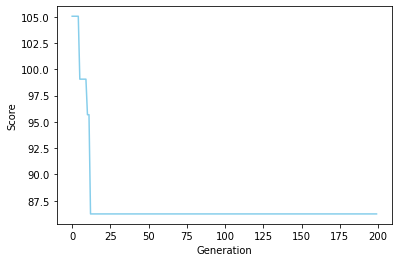

Best Chromosome : [4, 1, 3, 2, 0]


In [154]:
best,history = genetic_algorithm(cities,cost_mat,n_iter=200,verbose=False,print_interval=20,return_history=True)
plt.plot(range(len(history)), history, color="skyblue")
plt.xlabel('Generation')
plt.ylabel('Score')
plt.show()
print(f'Best Chromosome : {best}')